# ARIMA Forecasting - AAPL
This notebook loads historical stock price data for Apple (AAPL), fits an ARIMA model, and forecasts future closing prices.

In [33]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


#sns.set(style="whitegrid")

In [34]:
# Download + prepare data
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31")[["Close"]].dropna()
data.columns = [ticker]
data.index = pd.to_datetime(data.index)
data = data.asfreq('B').dropna()

# ADF test + p-value
result = adfuller(data[ticker])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

[*********************100%***********************]  1 of 1 completed

ADF Statistic: 0.24379440276306513
p-value: 0.9746136517994043


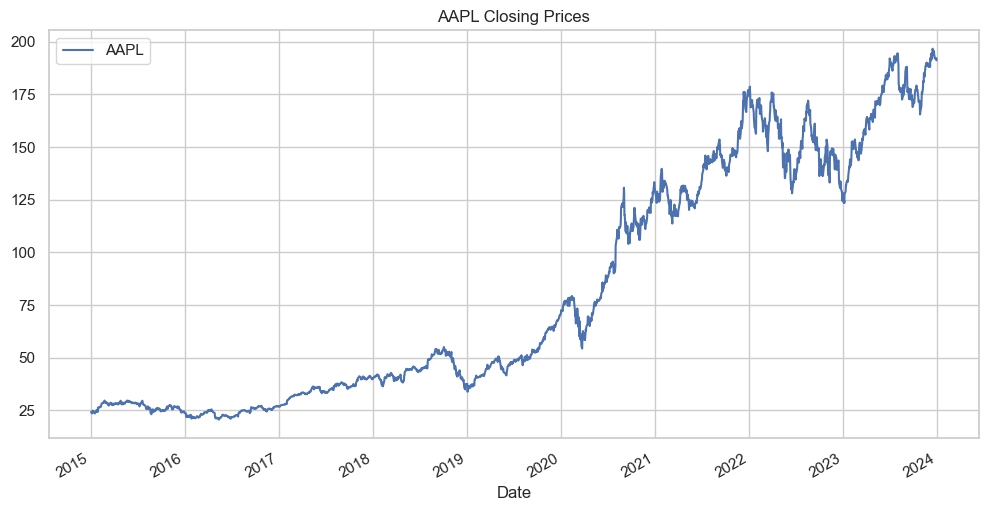

In [35]:
# Plot closing prices
data.plot(title=f"{ticker} Closing Prices", figsize=(12, 6))
plt.show()

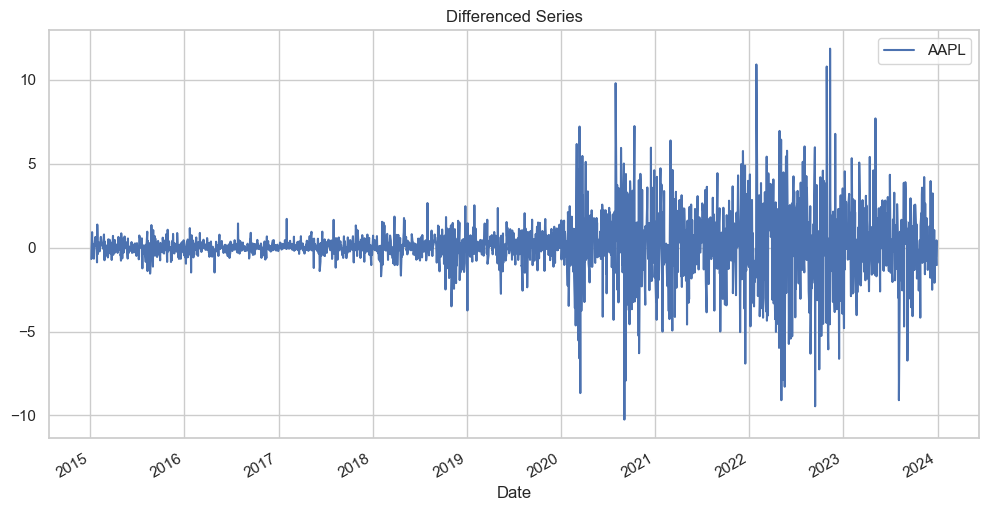

In [36]:
# Differencing
data_diff = data.diff().dropna()
data_diff.plot(title="Differenced Series", figsize=(12, 6))
plt.show()

In [37]:
# Train/test split
train = data[:'2022']
test = data['2023':]
train_values = train[ticker].values
test_values = test[ticker].values
test_index = test.index

# Fit model
model = auto_arima(
    train_values,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("Selected ARIMA order:", model.order)

# Forecast with confidence intervals
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_series = pd.Series(forecast, index=test_index)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7935.449, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7940.845, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7936.395, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7935.981, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7940.623, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7937.550, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7937.524, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7937.263, Time=1.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7933.240, Time=0.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7938.606, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7935.919, Time=2.49 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7927.090, Time=0.85 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=7938.551, Time=0.35 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : 

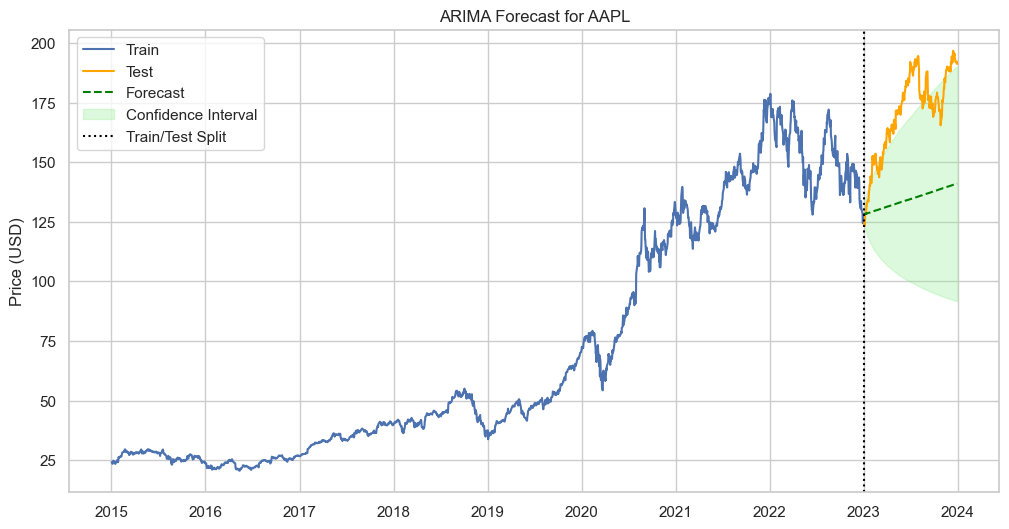

In [38]:
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[ticker], label='Train')
plt.plot(test.index, test[ticker], label='Test', color='orange')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='green', linestyle='--')
plt.fill_between(test_index, conf_int[:, 0], conf_int[:, 1], color='lightgreen', alpha=0.3, label='Confidence Interval')
plt.axvline(x=test.index[0], color='black', linestyle=':', label='Train/Test Split')
plt.title(f"ARIMA Forecast for {ticker}")
plt.ylabel("Price (USD)")
plt.legend()

# Save png to output folder
plt.savefig("../output/aapl_forecast_plot.png", dpi=300, bbox_inches='tight')

plt.show()

In [39]:
# Evaluate forecast
mask = ~np.isnan(test_values) & ~np.isnan(forecast) & ~np.isinf(test_values) & ~np.isinf(forecast)
true_clean = test_values[mask]
pred_clean = forecast[mask]

if len(true_clean) > 0:
    mse = mean_squared_error(true_clean, pred_clean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_clean, pred_clean)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
else:
    print("Not enough valid forecast data to evaluate.")

# Baseline comparison
naive_forecast = pd.Series(train[ticker].iloc[-1], index=test.index)
naive_mse = mean_squared_error(test[ticker], naive_forecast)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive RMSE: {naive_rmse:.2f}")

RMSE: 39.04
MAE: 36.38
Naive RMSE: 46.00


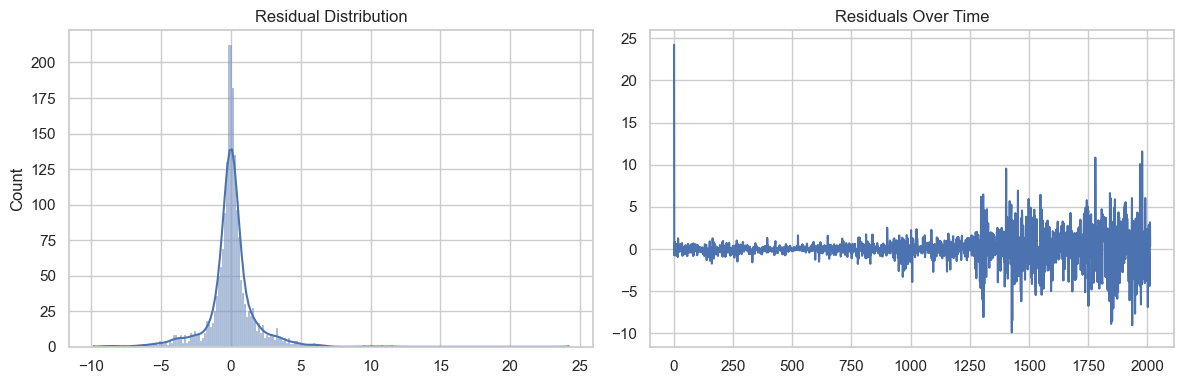

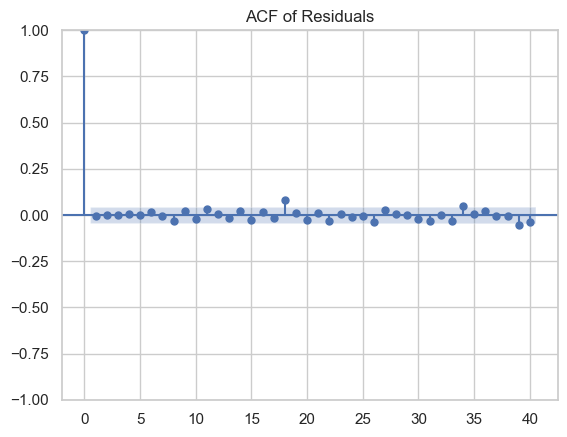

In [40]:
# Residual diagnostics
resid = model.resid()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(resid, kde=True)
plt.title("Residual Distribution")

plt.subplot(1, 2, 2)
plt.plot(resid)
plt.title("Residuals Over Time")
plt.tight_layout()
plt.show()

plot_acf(resid, lags=40)
plt.title("ACF of Residuals")
plt.show()


In [41]:
import os
os.makedirs("output", exist_ok=True)

# Save forecast vs. actual to CSV
comparison_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test[ticker].values,
    'Forecast': forecast_series.values
})

# Set 'Date' as index
comparison_df.set_index('Date', inplace=True)

# Save to CSV
csv_path = '../output/aapl_forecast_vs_actual.csv'
comparison_df.to_csv(csv_path)

print(f"✅ Forecast vs. actual saved to '{csv_path}'")



✅ Forecast vs. actual saved to '../output/aapl_forecast_vs_actual.csv'
